<a href="https://colab.research.google.com/github/Alinka7/Deep-Learning/blob/main/part1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Making essential imports
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.transform import resize, rescale
from skimage.io import imread
import os
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense ,Conv2D,MaxPooling2D ,Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
# Common
import keras
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from numpy import zeros, random

# Data
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Data viz
import matplotlib.pyplot as plt

# Model
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Dropout, BatchNormalization, Layer, Input, add, multiply, UpSampling2D

# Model Viz
from tensorflow.keras.utils import plot_model

# Callback
from keras.callbacks import Callback
from glob import glob
from numpy import zeros, random

In [ ]:
# here I make normalization to move from the range 0-255 to 0-1.
# and cnahge the size of the input image: (255, 255) 
def load_image(path):
    img = resize(img_to_array(load_img(path))/255. , (256,256))
    return img

In [ ]:
# here I make some preprocess for masks and images together:
# sort the orer of  masks
# change the name of masks
root_path = '/content/drive/MyDrive/Colab Notebooks/t/images/'
image_paths = sorted(glob(root_path + f"*.png"))
mask_paths = []
for path in image_paths:
    mask_path = path.replace('images','segmentations')
    mask_path = mask_path.replace('.png','_seg0.png')
    mask_paths.append(mask_path)
print(f"Total Number of Images  : {len(image_paths)}")

Total Number of Images  : 832


In [ ]:
images = zeros(shape=(len(image_paths), 256, 256, 3)) # set the dimensions 
masks = zeros(shape=(len(image_paths), 256, 256, 3))
for n, (img_path, mask_path) in tqdm(enumerate(zip(image_paths, mask_paths)), desc="Loading"):
    images[n] = load_image(img_path) # preprocess img using already created function
    masks[n] = load_image(mask_path) # preprocess img using already created function

Loading: 832it [04:45,  2.92it/s]


In [ ]:
imagesTrain = images[:700] # the first 700 images to the train data
masksTrain = masks[:700] # the first 700 masks to the train data

imagesTest = images[700:] # the last 132 images to the test data
masksTest = masks[700:] # the last 132 masks to the test data

In [ ]:
train = tf.convert_to_tensor(imagesTrain) # move from numpy array to tensor
train*=255 # move to the form of images 0-255 from 0-1
train = tf.dtypes.cast(train, tf.uint8) # change the data type to unit8

In [ ]:
test = tf.convert_to_tensor(imagesTest) # move from numpy array to tensor
test*=255 # move to the form of images 0-255 from 0-1
test = tf.dtypes.cast(test, tf.uint8) # change the data type to unit8

In [ ]:
@tf.function
# this function creates pairs of cropped images 
def build_data(data):
  cropped=tf.dtypes.cast(tf.image.random_crop(data / 255,(128,128,3)),tf.float32) # crop a random part of image with the size (128, 128)
  lr=tf.image.resize(cropped,(64,64))
  lr=tf.image.resize(lr,(128,128), method = tf.image.ResizeMethod.BICUBIC) # here we move to low resolution image using bicubic interpolation
  return (lr,cropped) # as a result we have the following pair: (low res, high res)

# this function creates low resolution image using bicubic interpolation
def downsample_image(image,scale):
  lr=tf.image.resize(image / 255,(image.shape[0]//scale, image.shape[1]//scale)) # resizing to the correct size
  lr=tf.image.resize(lr,(image.shape[0], image.shape[1]), method = tf.image.ResizeMethod.BICUBIC) # using bicubic interpolation
  return lr

In [ ]:
# Отже, використання num_parallel_calls=tf.data.AUTOTUNE
# дозволяє автоматично визначати кількість паралельних процесів,
# які потрібні для обробки даних у потоці tf.data.Dataset, що забезпечує
# максимальну швидкість обробки дани

In [ ]:
# here I create tf.data.Dataset object which has pairs: (low res img, high res img)
# num_parallel_calls - numbers of parallel processes (increase the speed)
train_dataset_mapped =  tf.data.Dataset.from_tensor_slices(train).map(build_data, num_parallel_calls = tf.data.AUTOTUNE)
test_dataset_mapped =  tf.data.Dataset.from_tensor_slices(test).map(build_data, num_parallel_calls = tf.data.AUTOTUNE)

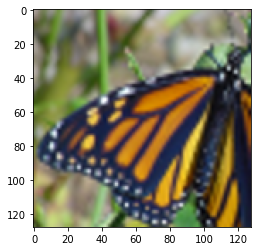

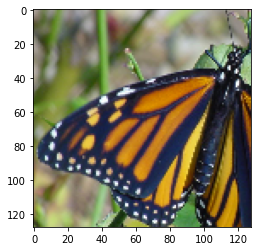

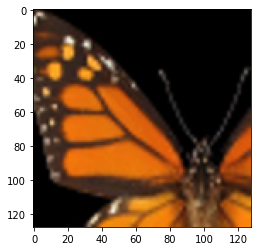

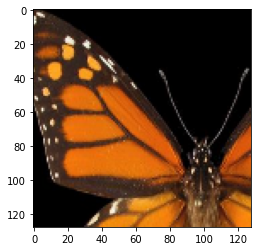

In [ ]:
for x in train_dataset_mapped.take(2):
  plt.imshow(x[0].numpy())
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()

In [ ]:
# creating model with architecture from article
SRCNN_915=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,9,padding='same',activation='relu'),  # number of filters = 64
                                                                    # layer performs convolution on the input image with a 9x9 kernel
                                                                    # add zeros to the edges of the input image so that the output image size is the same as the input size
                                                                    # functiion of activation = relu
    tf.keras.layers.Conv2D(64,1,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(3,5,padding='same',activation='relu')
])

# it is a loss function, which is defined as MSE
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean((y_true - y_pred)**2)

# here I train the created model with the following paramaters:
# optimizer: Adam with learning reate 0.001
# loss function: MSE (which was created earlier)
SRCNN_915.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss)

In [ ]:
train_dataset_mapped = tf.data.Dataset.from_tensor_slices(train).map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
val_dataset_mapped = tf.data.Dataset.from_tensor_slices(test).map(build_data, num_parallel_calls = tf.data.AUTOTUNE).batch(128)
# use 20 epoch for training the model
# batch(128) - it groups the resulting dataset into batches of 128 samples.
# Batching the data helps to improve training efficiency by reducing the number of times the model needs to access memory during training.
SRCNN_915.fit(train_dataset_mapped,epochs=15,validation_data=val_dataset_mapped)

Epoch 1/15
6/6 [==============================] - 169s 27s/step - loss: 0.1099 - val_loss: 0.0499
Epoch 2/15
6/6 [==============================] - 170s 28s/step - loss: 0.0477 - val_loss: 0.0248
Epoch 3/15
6/6 [==============================] - 172s 28s/step - loss: 0.0277 - val_loss: 0.0236
Epoch 4/15
6/6 [==============================] - 173s 29s/step - loss: 0.0227 - val_loss: 0.0159
Epoch 5/15
6/6 [==============================] - 174s 28s/step - loss: 0.0159 - val_loss: 0.0129
Epoch 6/15
6/6 [==============================] - 169s 28s/step - loss: 0.0128 - val_loss: 0.0107
Epoch 7/15
6/6 [==============================] - 175s 29s/step - loss: 0.0108 - val_loss: 0.0085
Epoch 8/15
6/6 [==============================] - 177s 29s/step - loss: 0.0091 - val_loss: 0.0082
Epoch 9/15
6/6 [==============================] - 172s 28s/step - loss: 0.0083 - val_loss: 0.0069
Epoch 10/15
6/6 [==============================] - 170s 28s/step - loss: 0.0076 - val_loss: 0.0064
Epoch 11/15
6/6 [==

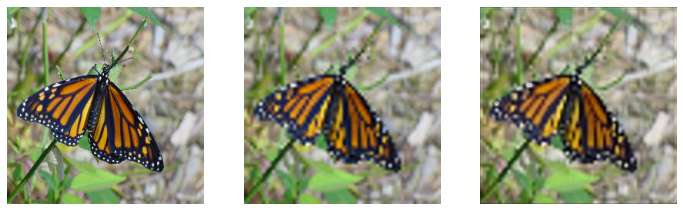

In [ ]:
# making the resulted vizualization
for x in tf.data.Dataset.from_tensor_slices(train).take(1):
  fig=plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.imshow(x.numpy()) # the input image
  plt.axis('off')
  plt.subplot(1,3,2)
  lr=downsample_image(x.numpy(),4)
  plt.imshow(lr.numpy())  # bicubic interpolated image
  plt.axis('off')
  plt.subplot(1,3,3)
  pred=SRCNN_915(np.array([lr]))
  plt.imshow(tf.dtypes.cast(pred[0]*255, tf.uint8).numpy()) # super resolution image
  plt.axis('off')
  plt.show()

**FGSM ON resoluion data**


In [ ]:
# load the pretrained model MobileNetV2 
# include_top = True - includes the final cassification layer, which is trained to recognize 1000 classes of objects in the ImageNet dataset
# use pre-trained ImageNet weights
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
# the weights of the pre-trained model will not be updated during training (because I use pre-trained ImageNet weights)
pretrained_model.trainable = False

# ImageNet labels
# decode the predictions made by a MobileNetV2 model that has been trained on the ImageNet dataset
# Ця функція отримує на вхід список передбачень, де кожне передбачення представлено як одновимірний масив NumPy довжиною 1000, що містить ймовірності належності зображення до кожного з 1000 класів ImageNet. Потім функція повертає список кортежів, де кожний кортеж містить ідентифікатор класу, назву класу та ймовірність відповідного передбачення.
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 0s 0us/step


In [ ]:
# preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.convert_to_tensor(image)
  image = tf.cast(image, tf.float32) # convert to float32 data type
  image = tf.image.resize(image, (224, 224)) # the size of the input image to MobileNetV2 must be (224, 224)
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image) # prepocess function of the MobileNetV2 model
  # this function makes data suitable for use with the MobileNetV2: scaling the pixel values to the range [-1, 1], normalizing, move from RGB to BGR
  image = tf.expand_dims(image, axis=0)# adds an extra dimension to the beginning of the image array.
  # This is often used when processing a single image with a neural network that expects a batch of images as input
  return image

# extract label from probability vector which is the best for the image
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [ ]:
# function fo displaying the image with predicted label
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image)) #get label of images, the level of confidence
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5) # displaying the imgage 
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description, # adding extra info
                                                   label, confidence*100))
  plt.show()

In [ ]:
elem = tf.dtypes.cast(pred[0]*255, tf.uint8).numpy() # take one image like an examle
data = preprocess(elem) # preprocess this image fot using MobileNetV2
preds = pretrained_model.predict(data) # to predict class for butterfly
_, label, _ = get_imagenet_label(preds) # extract the name of the butterfly
admiral_class_index = np.argmax(preds[0])

1/1 [==============================] - 0s 61ms/step


In [ ]:
# CategoricalCrossentropy loss function which is used in classification problems
# Функція втрати CategoricalCrossentropy зазвичай використовується в задачах класифікації, де вихід моделі є розподілом ймовірностей по заданому набору класів. Вона використовується для обчислення втрат між передбаченими ймовірностями класів та справжніми мітками класів.
# Буде використовуватися для обчислення втрат між передбаченими ймовірностями класів та справжніми мітками класів під час навчання моделі.
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image) 
    prediction = pretrained_model(input_image) # make class prediction for the input image
    loss = loss_object(input_label, prediction) # calculate loss between input_label and predicted label

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

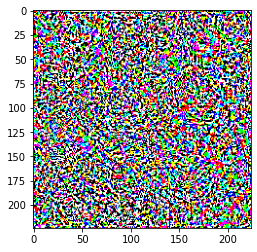

In [ ]:
# Get the input label of the image.
label = tf.one_hot(admiral_class_index, preds.shape[-1])  # creates a one-hot tensor for the class index admiral_class_index in the classification output 
                                                          # with a length equal to the number of classes in the model (1000)
label = tf.reshape(label, (1, preds.shape[-1])) # reshape the one-hot tensor to have a shape of (1, num_classes) == (1, 1000)

perturbations = create_adversarial_pattern(data, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # to change [-1, 1] to [0,1]

1/1 [==============================] - 0s 61ms/step


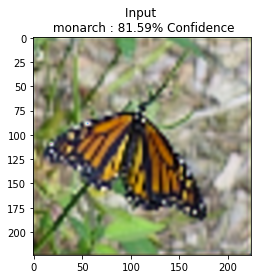

1/1 [==============================] - 0s 63ms/step


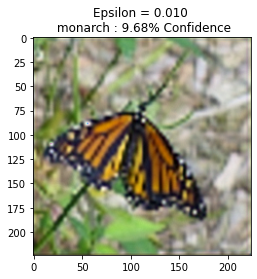

1/1 [==============================] - 0s 62ms/step


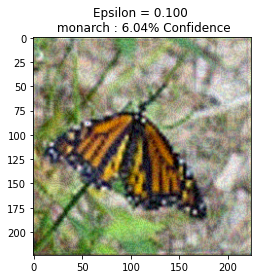

1/1 [==============================] - 0s 57ms/step


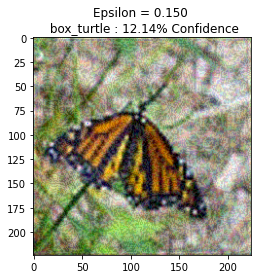

1/1 [==============================] - 0s 62ms/step


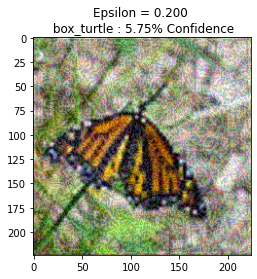

1/1 [==============================] - 0s 61ms/step


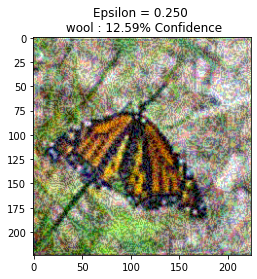

In [ ]:
epsilons = [0, 0.01, 0.1, 0.15, 0.2, 0.25] # choose epsilon - multiplier to ensure small disturbances.
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = data + eps*perturbations # add this 'noise' to the image 
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

**SEGMENATION ON DATA RESOLUTION**

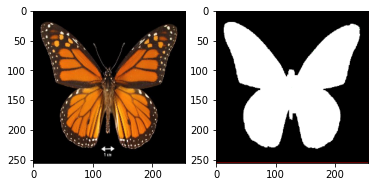

In [ ]:
plt.subplot(1,2,1)
plt.imshow(imagesTrain[1])
plt.subplot(1,2,2)
plt.imshow(masksTrain[1])
plt.show()

In [ ]:
# this function contains two convolutional layers that are used in the encoder and decoder parts of U-Net
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    # the first conv layer
    x = tf.keras.layers.Conv2D(filters = numFilters,
                               kernel_size = (kernelSize, kernelSize), # size of convolutional kernel 
                               kernel_initializer = 'he_normal', # initialization method for the kernel weights of the layer 
                               padding = 'same') (inputTensor)  # pads the input image with zeros in such a way that the output image has the same spatial dimensions as the input image
                               # as input it takes tensor - input image
    x = tf.keras.layers.BatchNormalization()(x) # normalizing the input of each layer with respect to its mean and variance.
    x =tf.keras.layers.Activation('relu')(x) # activation function relu
    
    # the second conv layer
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    x = tf.keras.layers.BatchNormalization()(x)  
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1):

    # extract features from the image, thereby reducing the image in height and width but simultaneously growing it in depth
    # (an encoder makes a latent representation for the image)
    # defining encoder Path

    # here we can see that numy filetrs is increased: it is growing it in depth
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3) # creates two 2D-conv layers with kernel 3 
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1) # pooling with the window of size 2
    p1 = tf.keras.layers.Dropout(droupouts)(p1) # randomly sets input tensor elements (10%) to zero
    
    # the same logic
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3) 
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3)
    
    # defining decoder path
    # decode the latent representation
    # increse the size of the image which we get adter encoder
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, #
                                         (3, 3), # kernel size
                                         strides = (2, 2), # the step with which the kernel moves over the input image.
                                         padding = 'same')(c5) # pads the input image with zeros in such a way that the output image has the same spatial dimensions as the input image
    # important moment
    u6 = tf.keras.layers.concatenate([u6, c4]) # join two tensors: result of decoder and encoder, it helps to get more information (because take info from two parts)
                                               # it helps to save more details 
    u6 = tf.keras.layers.Dropout(droupouts)(u6) # randomly sets input tensor elements (10%) to zero
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3) # function of resulted decoder 
    


    # teh same logic
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3)
    
    # resulted layer of one conv layer with 3 filters and kernels of size  

    # У моделі U-Net в останньому шарі використовується функція активації Sigmoid, оскільки вона призводить до виведення значень між 0 і 1, що можна інтерпретувати як ймовірності. Оскільки в U-Net розв'язується задача сегментації зображень, де потрібно виділити області зображення, які містять об'єкти інтересу, функція активації Sigmoid підходить для виведення карт сегментації, оскільки значення пікселів в цих картах можна інтерпретувати як ймовірності належності пікселя до об'єкту інтересу або фону.
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [ ]:
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
myTransformer.fit(np.array(imagesTrain), np.array(masksTrain), epochs = 15)

Epoch 1/15
22/22 [==============================] - 728s 32s/step - loss: 0.5666 - accuracy: 0.4758
Epoch 2/15
22/22 [==============================] - 722s 33s/step - loss: 0.4206 - accuracy: 0.3260
Epoch 3/15
22/22 [==============================] - 705s 32s/step - loss: 0.3622 - accuracy: 0.2924
Epoch 4/15
22/22 [==============================] - 710s 32s/step - loss: 0.3069 - accuracy: 0.3804
Epoch 5/15
22/22 [==============================] - 715s 33s/step - loss: 0.2645 - accuracy: 0.4626
Epoch 6/15
22/22 [==============================] - 716s 33s/step - loss: 0.2287 - accuracy: 0.4760
Epoch 7/15
22/22 [==============================] - 709s 32s/step - loss: 0.2013 - accuracy: 0.4421
Epoch 8/15
22/22 [==============================] - 732s 33s/step - loss: 0.1785 - accuracy: 0.3692
Epoch 9/15
22/22 [==============================] - 712s 32s/step - loss: 0.1582 - accuracy: 0.3105
Epoch 10/15
22/22 [==============================] - 713s 32s/step - loss: 0.1531 - accuracy: 0.2763

In [ ]:
res = []
for x in test:
  lr=downsample_image(x.numpy(),4)
  pred=SRCNN_915(np.array([lr]))
  res.append(np.squeeze(pred))

In [ ]:
# function for getting predictions
def predict(valI,valM, model, shape = 256):
    ## getting and proccessing val data
    img = valI
    mask = valM
    mask = mask[0:5]
    
    imgProc = img [0:5]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

In [ ]:
Prediction, actuals, masks = predict(np.array(res) ,masksTest, myTransformer, shape = 256)

5/5 [==============================] - 33s 6s/step


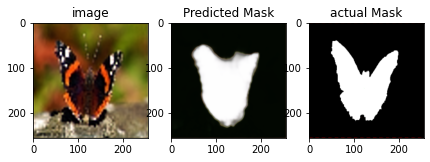

In [ ]:
Plotter(actuals[1], Prediction[1], masks[1])